In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'

# from jax import config
# config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import plotly.io as pio
pio.renderers.default = "browser"

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import cbvf_reachability as cbvf

from dyn_sys.MzNonlinearCar import MzNonlinearCar


In [2]:
dynamics = MzNonlinearCar()

# limits of the grid in degrees
x1_lim = 150
x2_lim = 60

x1_lim = x1_lim * jnp.pi / 180
x2_lim = x2_lim * jnp.pi / 180

grid = cbvf.Grid.from_lattice_parameters_and_boundary_conditions(cbvf.sets.Box(np.array([-x1_lim, -x2_lim]),
                                                                           np.array([x1_lim, x2_lim])),
                                                                           (500, 500))
values_vi = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 5 * jnp.pi / 180  # radius in radians
values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 5 * jnp.pi / 180  # radius in radians
initial_values = values_vi.copy()

solver_settings = cbvf.SolverSettings.with_accuracy(
    "very_high",
    hamiltonian_postprocessor=cbvf.solver.identity,
)



times = np.linspace(0, -0.5, 1000)

In [3]:
time = 0.
target_time = -0.3
solver_settings = cbvf.SolverSettings.with_accuracy("cbvf",
                                                  hamiltonian_postprocessor=cbvf.solver.identity,
                                                  gamma=5)
target_values_vi = cbvf.step_cbvf(solver_settings, dynamics, grid, time, values_vi, target_time, initial_values)
solver_settings = cbvf.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=cbvf.solver.backwards_reachable_tube)
target_values = cbvf.step(solver_settings, dynamics, grid, time, values, target_time)

100%|##########|  0.3000/0.30000001192092896 [00:06<00:00, 21.18s/sim_s]
100%|##########|  0.3000/0.30000001192092896 [00:06<00:00, 23.10s/sim_s]


In [4]:
# target_values = cbvf.solve_vi(solver_settings, dynamics, grid, times, values, initial_values)
# solver_settings = cbvf.SolverSettings.with_accuracy(
#     "very_high",
#     hamiltonian_postprocessor=cbvf.solver.backwards_reachable_tube,
# )
# target_values = cbvf.solve(solver_settings, dynamics, grid, times, initial_values)

In [5]:
plot_time_index = len(times) // 2

<Figure size 640x480 with 0 Axes>

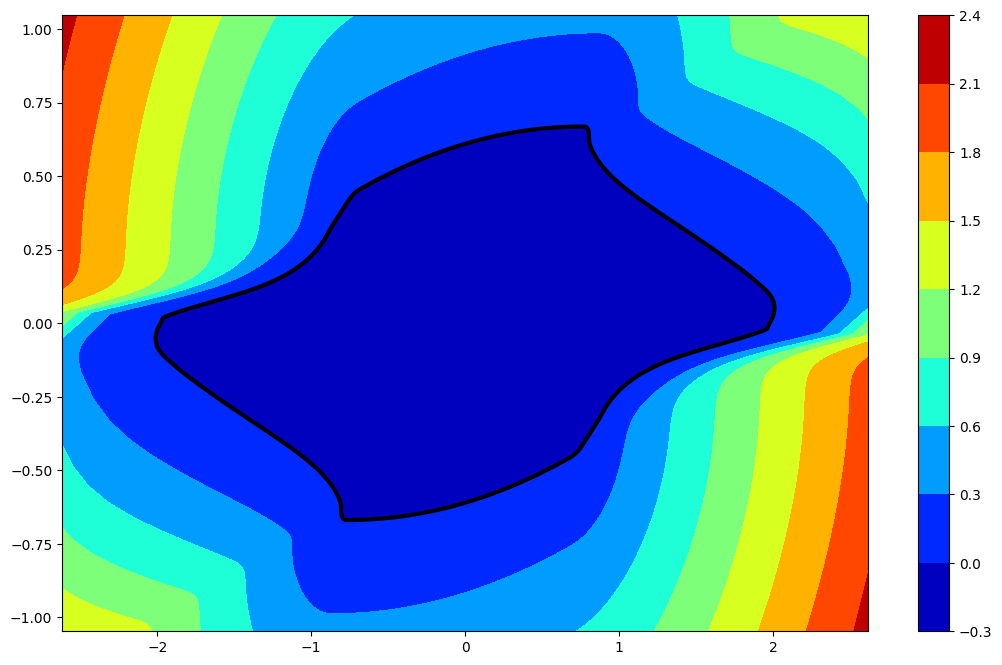

In [6]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :].T,
            levels=0,
            colors="black",
            linewidths=3)

<Figure size 640x480 with 0 Axes>

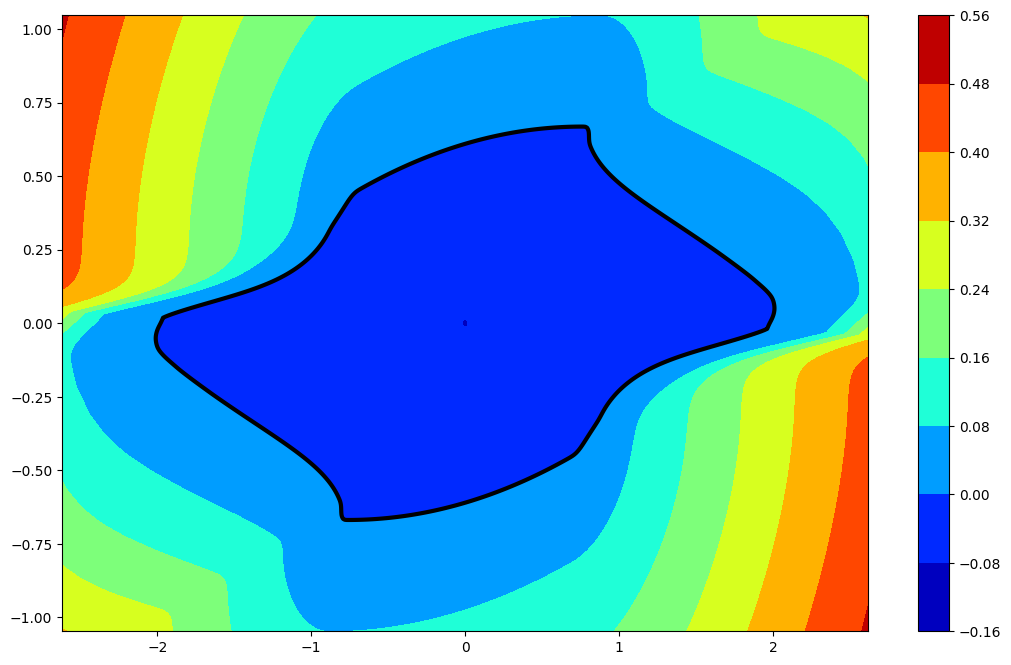

In [7]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values_vi[:, :].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values_vi[:, :].T,
            levels=0,
            colors="black",
            linewidths=3)

In [8]:
f = go.Figure(data=go.Surface(z=target_values[:, :].T,
                                         x=grid.coordinate_vectors[0],
                                         y=grid.coordinate_vectors[1],
                                         colorscale="Jet",
                                         contours={
                                             "z": {
                                                 "show": True,
                                                 "start": 0.00,
                                                 "end": 0.00,
                                                 "size": 1
                                             }
                                         }))
f.update_layout(title="Reachable Set for MzNonlinearCar (norm)",
                  scene=dict(xaxis_title="x1",
                             yaxis_title="x2",
                             zaxis_title="value"),
                  width=800,
                  height=800,
                  xaxis=dict(range=[-x1_lim, x1_lim]),
                  yaxis=dict(range=[-x2_lim, x2_lim]),
                  scene_aspectmode='cube')
f.show()

In [9]:
f = go.Figure(data=go.Surface(z=target_values_vi[:, :].T,
                                         x=grid.coordinate_vectors[0],
                                         y=grid.coordinate_vectors[1],
                                         colorscale="Jet",
                                         contours={
                                             "z": {
                                                 "show": True,
                                                 "start": 0.00,
                                                 "end": 0.00,
                                                 "size": 1
                                             }
                                         }))
f.update_layout(title="Reachable Set for MzNonlinearCar (Alt)",
                  scene=dict(xaxis_title="x1",
                             yaxis_title="x2",
                             zaxis_title="value"),
                  width=800,
                  height=800,
                  xaxis=dict(range=[-x1_lim, x1_lim]),
                  yaxis=dict(range=[-x2_lim, x2_lim]),
                  scene_aspectmode='cube')
f.show()

In [10]:
f = go.Figure(data=go.Surface(z=target_values_vi[:, :].T - target_values[:, :].T,
                                         x=grid.coordinate_vectors[0],
                                         y=grid.coordinate_vectors[1],
                                         colorscale="Jet",
                                         contours={
                                             "z": {
                                                 "show": True,
                                                 "start": 0.00,
                                                 "end": 0.00,
                                                 "size": 1
                                             }
                                         }))
f.update_layout(title="Difference in sets",
                  scene=dict(xaxis_title="x1",
                             yaxis_title="x2",
                             zaxis_title="value"),
                  width=800,
                  height=800,
                  xaxis=dict(range=[-x1_lim, x1_lim]),
                  yaxis=dict(range=[-x2_lim, x2_lim]),
                  scene_aspectmode='cube')
f.show()